<a href="https://colab.research.google.com/github/maheshmechengg/LSTM/blob/main/TweetSentiment_Analysis_LM_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tweet Sentiment Analysis using tweet

In [1]:
import pandas as pd

In [2]:
df=pd.read_csv('/content/tweet_data.csv')

In [3]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# Removing punctuations
data=df.copy() #updated train to df
data = data.drop(['id','keyword','location'], axis = 1)
# Remove special characters; . , ! ? # @ -
data['text'].replace("[^a-zA-Z]"," ",regex=True, inplace=True)

In [5]:
data.head(1)

,text,target
0,Our Deeds are the Reason of this earthquake M...,1


In [6]:
data['text'].str.lower()

0       our deeds are the reason of this  earthquake m...
1                  forest fire near la ronge sask  canada
2       all residents asked to  shelter in place  are ...
3              people receive  wildfires evacuation or...
4       just got sent this photo from ruby  alaska as ...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609     aria ahrary  thetawniest the out of control w...
7610    m            utc   km s of volcano hawaii  htt...
7611    police investigating after an e bike collided ...
7612    the latest  more homes razed by northern calif...
Name: text, Length: 7613, dtype: object

In [7]:
headlines = []
for i in range(len(data['text'])):
  headlines.append(data['text'][i].lower())
headlines[0]

'our deeds are the reason of this  earthquake may allah forgive us all'

In [8]:
text = ' '.join(headlines)

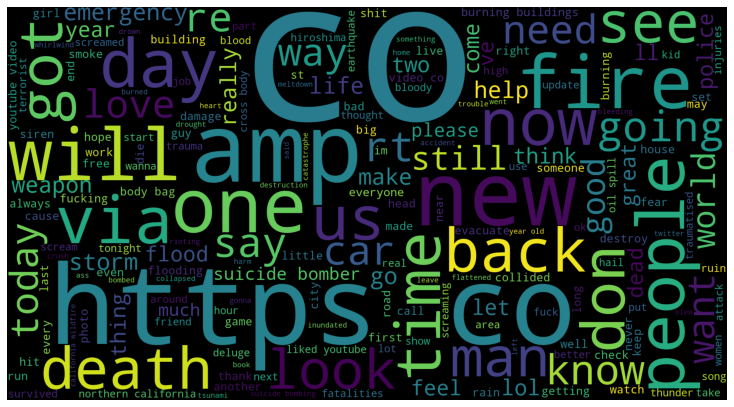

In [9]:
# Create WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
wordcloud = WordCloud(width=1980, height=1080).generate(text)
fig =  plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(wordcloud)
plt.tight_layout(pad=0)

More frequent word will shown as bigger than others like density plot

# Apply Standard Machine Learning first

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpuss = []
for i in range(0, len(headlines)):
    #print(i)
    review = re.sub('[^a-zA-Z]', ' ', headlines[i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpuss.append(review)  

In [ ]:
## implement BAG OF WORDS without stemming
countvector=CountVectorizer(ngram_range=(2,2))
traindataset=countvector.fit_transform(headlines[:5329])


In [52]:
train_label = df['target'][:5329]
test_label = df['target'][5330:]

In [ ]:
## implement BAG OF WORDS with stemming & removing stop words
countvector_stm=CountVectorizer(ngram_range=(2,2))
stem_traindataset=countvector_stm.fit_transform(corpuss[:5329])


In [ ]:
#Test data without stemming
test_dataset = countvector.transform(headlines[5330:])


In [ ]:
#Test data with stemming
stem_test_dataset = countvector_stm.transform(corpuss[5330:])
test_label = df['target'][5330:]

# First Apply Naive Bayse model

In [ ]:
naive = MultinomialNB()
naive.fit(traindataset,train_label)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
## Predict for the Test Dataset
pred_NB = naive.predict(test_dataset)

In [ ]:
## Model performance
matrix_NB=confusion_matrix(test_label,pred_NB)
print(matrix_NB)
score_NB=accuracy_score(test_label,pred_NB)
print(score_NB)
report_NB=classification_report(test_label,pred_NB)
print(report_NB)

[[1016  258]
 [ 403  606]]
0.7104686815593517
              precision    recall  f1-score   support

           0       0.72      0.80      0.75      1274
           1       0.70      0.60      0.65      1009

    accuracy                           0.71      2283
   macro avg       0.71      0.70      0.70      2283
weighted avg       0.71      0.71      0.71      2283



In [ ]:
nb_stem = naive.fit(stem_traindataset,train_label)

In [ ]:
## Predict for the Test Dataset
pred_NBSTM = nb_stem.predict(stem_test_dataset)

In [ ]:
## Model performance
matrix_NB=confusion_matrix(test_label,pred_NBSTM)
print(matrix_NB)
score_NB=accuracy_score(test_label,pred_NBSTM)
print(score_NB)
report_NB=classification_report(test_label,pred_NBSTM)
print(report_NB)

[[1063  211]
 [ 491  518]]
0.6925098554533509
              precision    recall  f1-score   support

           0       0.68      0.83      0.75      1274
           1       0.71      0.51      0.60      1009

    accuracy                           0.69      2283
   macro avg       0.70      0.67      0.67      2283
weighted avg       0.70      0.69      0.68      2283



### With stemming & removing stop words it reduces the score from model

# Apply Naive Bayse with Hyperparameter tunning

In [47]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, traindataset, train_label, scoring="roc_auc", cv=kf)

    return auc.mean()

The MultinominalNB class only have one hypterparameter - alpha. The code below will help us find the alpha value that gives us the highest CV AUC score.

In [48]:
import numpy as np
res = pd.Series([get_auc_CV(MultinomialNB(i))
                 for i in np.arange(1, 10, 0.1)],
                index=np.arange(1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

NameError: ignored

In [ ]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=1.1)
nb_model.fit(traindataset, train_label)
pred_nb = nb_model.predict(test_dataset)


In [ ]:
## Model performance
matrix_NB=confusion_matrix(test_label,pred_nb)
print(matrix_NB)
score_NB=accuracy_score(test_label,pred_nb)
print(score_NB)
report_NB=classification_report(test_label,pred_nb)
print(report_NB)

We are already getting same performance from base model (because alpha are close)

# Final to get output

In [ ]:
# Function to get prediction from model
def tweet_analyze(txt, model):
  txt = re.sub('[^a-zA-Z]', ' ', txt)
  txt = [txt.lower()]
  txt = countvector.transform(txt)

  tt_pred = model.predict(txt)
  return ["There is risky situation" if tt_pred == 1 else "There is normal situation" ]


In [ ]:
tweet_analyze('There is fire in mall', base_model)

['There is risky situation']

#For testing model on inputs

In [ ]:
data['text'][0]

'our deeds are the reason of this  earthquake may allah forgive us all'

In [ ]:
test_sent  = 'Forest fire near La Ronge Sask. Canada'
test_sent = re.sub('[^a-zA-Z]', ' ', test_sent)
test_sent = test_sent.lower()
test_sent = test_sent.split()
    
test_sent = [ps.stem(word) for word in test_sent] # if not word in stopwords.words('english')]
test_sent = ' '.join(test_sent)
print(test_sent)

forest fire near la rong sask canada


In [ ]:
x = test_sent.split()
x

['forest', 'fire', 'near', 'la', 'rong', 'sask', 'canada']

In [ ]:
x = tokenizer.texts_to_sequences(x)

In [ ]:
x = pad_sequences(x, maxlen = max_len)

In [ ]:
tt = model1.predict_classes(x)

NameError: ignored

In [ ]:
tt

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

In [ ]:
np.max(tt) == 1

False

In [ ]:
# Function to get prediction from model
def tweet_LSTM(txt, LSmodel):
  txt = re.sub('[^a-zA-Z]', ' ', txt)
  txt = txt.lower()
  txt = txt.split()
    
  txt = [ps.stem(word) for word in test_sent if not word in stopwords.words('english')]
  txt = ' '.join(txt)
  txt = txt.split()
  txt = tokenizer.texts_to_sequences(txt)
  txt = pad_sequences(txt, maxlen = max_len)

  tt = LSmodel.predict_classes(txt)
  print(np.argmax(tt))
  return ["There is risky situation" if np.max(tt) == 1 else "There is normal situation" ]

In [ ]:
tweet_LSTM('There was a fire & due to that many deaths happened', model2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


InternalError: ignored

#BERT Tokenizer

In [11]:
!pip install transformers

     |████████████████████████████████| 2.5MB 7.4MB/s 
     |████████████████████████████████| 3.3MB 50.7MB/s 
     |████████████████████████████████| 901kB 53.5MB/s 


### Tokenizing & format inputs

In [13]:
import re
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Replace '#;' with ''
    text = re.sub('[^a-zA-Z]', ' ', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [14]:
# Print sentence 0
print('Original: ', df['text'][0])
print('Processed: ', text_preprocessing(df['text'][0]))

Original:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Processed:  Our Deeds are the Reason of this earthquake May ALLAH Forgive us all


In [15]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [16]:
import torch
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split

In [17]:
# Concatenate train data and test data
all_tweets = np.concatenate([df['text']])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  84


In [18]:
Xx_train, Xx_val, Yy_train, Yy_val =\
    train_test_split(df['text'], df['target'], test_size=0.3, random_state=2020)

Let's tokenize data

In [19]:
# Specify `MAX_LEN`
MAX_LEN = 80

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([df['text'][0]])[0].squeeze().numpy())
print('Original: ', df['text'][0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(Xx_train)
val_inputs, val_masks = preprocessing_for_bert(Xx_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Token IDs:  [101, 2256, 15616, 2024, 1996, 3114, 1997, 2023, 8372, 2089, 16455, 9641, 2149, 2035, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


#Set GPU

In [20]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


Data Preprocessing

In [21]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in Xx_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in Xx_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

CPU times: user 11.6 s, sys: 1.25 s, total: 12.8 s
Wall time: 12.8 s


2.2. Create PyTorch DataLoader

In [ ]:
## When issue with dataloader

In [ ]:
from torch.utils.data import Dataset

class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        return self.dataframe.iloc[index]

In [ ]:
#train_labels = torch.tensor(Yy_train)
val_labels = torch.tensor(Yy_val.to_numpy())

In [ ]:
len(val_inputs)

2284

In [24]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(Yy_train.to_numpy())
val_labels = torch.tensor(Yy_val.to_numpy())

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [25]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 18.9 ms, sys: 988 µs, total: 19.9 ms
Wall time: 19.9 ms


In [26]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [27]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [45]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.592796   |     -      |     -     |   10.13  
   1    |   40    |   0.471276   |     -      |     -     |   9.81   
   1    |   60    |   0.427248   |     -      |     -     |   9.54   
   1    |   80    |   0.458760   |     -      |     -     |   9.30   
   1    |   100   |   0.432669   |     -      |     -     |   9.13   
   1    |   120   |   0.417993   |     -      |     -     |   9.00   
   1    |   140   |   0.451103   |     -      |     -     |   8.93   
   1    |   160   |   0.399395   |     -      |     -     |   8.98   
   1    |   166   |   0.397395   |     -      |     -     |   2.52   
----------------------------------------------------------------------
   1    |    -    |   0.455102   |  0.408158  |   83.39   |   89.23  
---------------------------------------------------------------------

###  Evaluation on Validation Set

In [29]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [31]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.8906
Accuracy: 83.80%


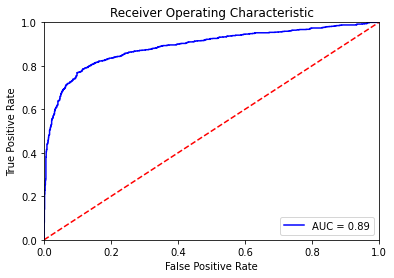

In [46]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, Yy_val)

In [54]:
test_label = df['target'][5329:]

In [57]:
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report 
threshold = 0.5
preds = np.where(probs[:, 1] > threshold, 1, 0)

## Model performance
matrix_BERT=confusion_matrix(test_label,preds)
print(matrix_BERT)
score_BERT=accuracy_score(test_label,preds)
print(score_BERT)
report_BERT=classification_report(test_label,preds)
print(report_BERT)

[[725 550]
 [603 406]]
0.4951838879159369
              precision    recall  f1-score   support

           0       0.55      0.57      0.56      1275
           1       0.42      0.40      0.41      1009

    accuracy                           0.50      2284
   macro avg       0.49      0.49      0.49      2284
weighted avg       0.49      0.50      0.49      2284



# Test the BERT Model on user input tweets

In [72]:
df['text'][6]

'#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas'

In [89]:
def tweetBERT(txt):
  test_sent, test_masks = preprocessing_for_bert(txt)

  # Create the DataLoader for our test set
  test_dataset = TensorDataset(test_sent, test_masks)
  test_sampler = SequentialSampler(test_dataset)
  test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

  # Compute predicted probabilities on the test set
  probs = bert_predict(bert_classifier, test_dataloader)

  # Get predictions from the probabilities
  threshold = 0.5
  
  preds = np.where(probs[:, 0] > threshold, 1, 0)
  pred = np.sum(preds)/len(preds)
  print(pred)
  out = pred

  # Number of tweets predicted non-negative
  return ["Number of tweets predicted negative: "+ str(out) if out == 1 else "Number of tweets predicted non-negative: "+str(out)]


In [92]:
tweetBERT(df['text'][0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


1.0


['Number of tweets predicted negative: 1.0']

#We are getting promising output from the model, impressed with performance of BERT (that's why it called state of Art model for NLP)